In [10]:
'''author:boyang yan
   code for data preprocess'''


'author:boyang yan\n   code for data preprocess'

In [5]:
'''import page''' 
import scipy.io as scio
import numpy as np
from collections import defaultdict
import pickle

In [6]:
'''
数据集读取，mat文件里的格式如下

rating.mat

rating.mat includes the rating information. there are five columns and they are userid, productid, categoryid, rating, helpfulness, respectively. 

*****************************************************************
For example, for one row
(1,2,3,4,5)

It means that user 1 gives a rating of 4 to the product 2 from the category 3. The helpfulness of this rating is 5. 

*****************************************************************************


===============================================================================================
trustnetwork.mat

trustnetwork.mat includes the trust relations between users. There are two columns and both of them are userid.

*************************************************************************************
for example, for one row,
(1,2)

it means that user 1 trusts user 2.
*************************************************************************************


'''
path = 'data/ciao'#数据集的相对路径
trust = scio.loadmat(path + '/trustnetwork.mat')
trust = trust['trustnetwork']
print(trust)#社交网络
rating = scio.loadmat(path + '/rating.mat')
rating = rating['rating']
print(rating)#用户-物品交互网络

[[   1    2]
 [   1    3]
 [   1    4]
 ...
 [7374 7373]
 [7374 7369]
 [7375 5285]]
[[     1      1      1      3      1]
 [     1      2      1      4      1]
 [     1      3      2      4      1]
 ...
 [  7375  72772     24      4      2]
 [  7375  74985     24      5      1]
 [  7375 101247     24      1      4]]


In [1]:
'''''' 
import pandas as pd
import scipy
from scipy import io
features_struct = scipy.io.loadmat('D:/exp/Social Recommendation/ESNRec/data/ciao/rating.mat')
features = features_struct['rating']
dfdata = pd.DataFrame(features)
datapath1 = 'D:/exp/Social Recommendation/ESNRec/data/ciao/ciao_rating.txt'
dfdata.to_csv(datapath1, index=False)

In [8]:
'''去掉没有社会关系的用户'''
delete = []
print(len(trust))
for i in range(len(trust)):
    if trust[i,0] == trust[i,1]:
        print(i)
        delete.append(i)
        print(i)
trust = np.delete(trust,delete,0)

print(len(trust))
'''
numpy.delete(arr, obj, axis)

arr：需要处理的矩阵
obj：在什么位置处理
axis：这是一个可选参数，axis = None，1，0

axis=None：arr会先按行展开，然后按照obj，删除第obj-1（从0开始）位置的数，返回一个行矩阵。
axis = 0：arr按行删除
axis = 1：arr按列删除
所有操作都是在arr的副本进行，需要有变量接收返回值。

'''

111781
111781


'\nnumpy.delete(arr, obj, axis)\n\narr：需要处理的矩阵\nobj：在什么位置处理\naxis：这是一个可选参数，axis = None，1，0\n\naxis=None：arr会先按行展开，然后按照obj，删除第obj-1（从0开始）位置的数，返回一个行矩阵。\naxis = 0：arr按行删除\naxis = 1：arr按列删除\n所有操作都是在arr的副本进行，需要有变量接收返回值。\n\n'

In [30]:
'''用户,评分，物品初始矩阵构建'''
dic_user_o2i = {}
i = 0
# build user index
for user in trust.reshape(-1,):
  if user in dic_user_o2i.keys():
    continue
  else:
    dic_user_o2i[user] = i
    i += 1
print('building from trust',len(dic_user_o2i))

delete = []
for i in range(len(rating)):
  if rating[i,0] not in dic_user_o2i.keys():
    delete.append(i)
rating = np.delete(rating, delete, 0)
print('rating_num:',len(rating))

dic_item_o2i = {}
i = 0
for item in rating[:, 1]:
  if item in dic_item_o2i.keys():
    continue
  else:
    dic_item_o2i[item] = i
    i += 1
print('number of items ', len(dic_item_o2i.keys()))

building from trust 7317
rating_num: 283320
number of items  104975


In [33]:
history_u_lists = defaultdict()
history_ur_lists = defaultdict()
history_v_lists = defaultdict()
history_vr_lists = defaultdict()
social_adj_lists = defaultdict()
item_adj_lists = defaultdict()
ratings_list = defaultdict()


    

data_total = []
print('building social_adj_lists')
for user in range(len(dic_user_o2i)):
  social_adj_lists[user] = []
for line in trust:
  social_adj_lists[dic_user_o2i[line[0]]].append(dic_user_o2i[line[1]])
  social_adj_lists[dic_user_o2i[line[1]]].append(dic_user_o2i[line[0]])
#print(len(dic_user_o2i)) #7317个用户
for user in range(len(dic_user_o2i)):
  social_adj_lists[user] = set(social_adj_lists[user])

print(social_adj_lists[7316])

print('building ratings_list')
i = 0
for rate in set(rating[:, 3]):
  ratings_list[rate] = i
  i += 1
  
print('building other dicts')
for user in range(len(dic_user_o2i)):
  history_u_lists[user] = []
  history_ur_lists[user] = []
for item in range(len(dic_item_o2i)):
  history_v_lists[item] = []
  history_vr_lists[item] = []
  
rating = rating[:, [0, 1, 3]]
np.random.shuffle(rating)
valid = rating[ : int(0.2 * len(rating))]
test = rating[int(0.2 * len(rating)) : int(0.4 * len(rating))]
train = rating[int(0.4 * len(rating)): ]

building social_adj_lists
{7313, 5278}
building ratings_list
building other dicts


In [8]:
def build_item_adj_lists(history_v_lists):
    adj_lists = {}
    for key in history_v_lists.keys():
        adj_lists[key] = []
    for key in history_v_lists.keys():
        for key_temp in history_v_lists.keys():
            if key != key_temp and len(set(history_v_lists[key]) | set(history_v_lists[key_temp])) != 0:
                if len(set(history_v_lists[key]) & set(history_v_lists[key_temp])) / len(set(history_v_lists[key]) | set(history_v_lists[key_temp])) > 0.5:
                    adj_lists[key].append(key_temp)
                    #print("添加item之间的连接")
    return adj_lists

print('validset')
validset = []
testset = []
for line in valid:
  user = line[0]
  item = line[1]
  rate = ratings_list[line[2]]
  if user in dic_user_o2i.keys():
    validset.append([dic_user_o2i[user], dic_item_o2i[item], rate])  
print('testset')
for line in test:
  user = line[0]
  item = line[1]
  rate = ratings_list[line[2]]
  if user in dic_user_o2i.keys():
    testset.append([dic_user_o2i[user], dic_item_o2i[item], rate]) 
print('trainingset')
for line in train:
  user = line[0]
  item = line[1]
  rate = ratings_list[line[2]]
  if user in dic_user_o2i.keys():
    history_u_lists[dic_user_o2i[user]].append(dic_item_o2i[item])
    history_ur_lists[dic_user_o2i[user]].append(rate)
    history_v_lists[dic_item_o2i[item]].append(dic_user_o2i[user])
    history_vr_lists[dic_item_o2i[item]].append(rate)
    data_total.append([dic_user_o2i[user], dic_item_o2i[item], rate])

print("line读取完成")
item_adj_lists = build_item_adj_lists(history_v_lists)
print("共享50%的user的item连接完成")

pickle_data = [history_u_lists, history_ur_lists, history_v_lists, history_vr_lists, data_total, validset, testset, social_adj_lists, item_adj_lists, ratings_list]
with open("data/epinions.pkl", 'wb') as fo:
    pickle.dump(pickle_data, fo)

validset
testset
trainingset
line读取完成
共享50%的user的item连接完成


In [69]:
#对数据的分析


inputfilename = 'D:/exp/Social Recommendation/ESNRec/data/ciao/ciao_rating.txt'
outputfilename = 'D:/exp/Social Recommendation/ESNRec/data/ciao/ciao_rating_stand.txt'
#user item sparse dense
outputfilename2 = 'D:/exp/Social Recommendation/ESNRec/data/ciao/ciao_item_sparse_dense.txt'
user, item, category, rating = [], [], [], []
with open(inputfilename, 'r') as f:
    # 将txt中的数据逐行存到列表lines
    lines = f.readlines()
    # j用于判断读了多少条
    j = 0
    for line in lines:
        temp = line.split('\t')
        t1 = temp[0] #user
        t2 = temp[1] #item
        t3 = temp[2] #category
        t4 = temp[3] #rating
        t5 = temp[4].strip('\n') #helpfulness,无用
        j = j + 1
        #print(t1)
        #print(t2)
        #print(t3)
        #print(t4)
        #print(t5)
        #print(temp)
        user.append(t1)
        item.append(t2)
        category.append(t3)
        rating.append(t4)

In [9]:
#1.利用user和rating，计算user对应的评分的标准差（点评分数）反应数据的离散程度，来分析模型在评分标准差大的和
#标准差小的用户之间哪种效果更好。标准差的大小反映的是用户喜好的极端性，是对物品都不喜欢还是对物品都喜欢

import math

def get_average(records):
    """
    平均值
    """
    return sum(records) / len(records)

def get_variance(records):
    """
    方差 反映一个数据集的离散程度
    """
    average = get_average(records)
    return sum([(x - average) ** 2 for x in records]) / len(records)
 
def get_standard_deviation(records):
    """
    标准差 == 均方差 反映一个数据集的离散程度
    """
    variance = get_variance(records)
    return math.sqrt(variance)
#利用user和rating，计算user对应的评分的标准差（点评分数）数据的离散程度
#print(len(user))
i = 0
ii = 0
usum = [[0 for col in range(1)] for row in range(7376)]
#uN = []
ustandard_deviation = []

for i in range(len(user)):
    #print(i)
    temp = user[i]
    temp2 = rating[i]
    temp = int(temp)
    temp2 = int(temp2)
    #print(usum[temp])
    usum[temp].append(temp2)
    #usum[temp] = sum(usum[temp])
    #ulen[temp] = ulen[temp] + 1
    #uave[temp] = usum[temp] / ulen[temp]

for ii in range(7317):
    del(usum[ii][0])
    #print(get_standard_deviation(usum[i]))
    #uN.append(ii)
    ustandard_deviation.append(get_standard_deviation(usum[ii]))

#print(ustandard_deviation[0]) 
#print(ustandard_deviation[389])
#print(ustandard_deviation[3791])
#print(ustandard_deviation[1645])
#print(ustandard_deviation[644])
#按照索引对标准差大小进行排序
data1 = sorted(range(len(ustandard_deviation)), key=lambda k: ustandard_deviation[k])
#print(data[1])

#将对应user索引以及其评分标准差按小到大排序，写入文件
f = open(outputfilename, 'a+')
i = 0
#for i in range(7317):
    #print(type(ustandard_deviation[data[i]]))
    #f.write(str(data1[i]) + ' ' + str(ustandard_deviation[data1[i]]) + '\n')
#f.close()

print('finished')

finished


In [70]:
#2.sparse dense user和item

i = 0
ii = 0
uItemN = [[0 for col in range(1)] for row in range(7376)]
uN = []


for i in range(len(user)):
    #print(i)
    temp = user[i]
    temp2 = item[i]
    temp = int(temp)
    temp2 = int(temp2)
    uItemN[temp].append(temp2)

for ii in range(7317):
    del(uItemN[ii][0])
    uN.append(len(uItemN[ii]))
    
#按照索引对交互的item数量进行排序
data2 = sorted(range(len(uN)), key=lambda k: uN[k])

#print(data)
#print(uN[0])
#print(uN[5904])
#print(uN[1])
#print(uN[1013])
#print(uN[331])
#将对应user索引以及其item数量按小到大排序，写入文件
f = open(outputfilename2, 'a+')
i = 0
for i in range(7317):
    f.write(str(data2[i]) + ' ' + str(uN[data2[i]]) + '\n')
f.close()

print('finished')

finished


In [33]:
#具体实现，数据集划分
#1.利用user和rating，计算user对应的评分的标准差（点评分数）反应数据的离散程度，来分析模型在评分标准差大的和
#标准差小的用户之间哪种效果更好。标准差的大小反映的是用户喜好的极端性，是对物品都不喜欢还是对物品都喜欢


#第一份 标准差最小的，此份数据集中说明用户对物品的评分都更相似
import scipy.io as scio
import numpy as np
from collections import defaultdict
import pickle

path = 'data/ciao'#数据集的相对路径
trust = scio.loadmat(path + '/trustnetwork.mat')
trust = trust['trustnetwork']
#print(trust)#社交网络
rating = scio.loadmat(path + '/rating.mat')
rating = rating['rating']
#print(rating)#用户-物品交互网络


ii = 0
#按方差由小到大排列成三份数据集
dic_user_stand1 = {}
dic_user_stand2 = {}
dic_user_stand3 = {}
for ii in range(7317):
    if ii < (1/3)*7317:
        dic_user_stand1[data1[ii]] = ii
    if ii < (2/3)*7317 and ii >= (1/3)*7317:
        dic_user_stand2[data1[ii]] = ii
    if ii >= (2/3)*7317:
        dic_user_stand3[data1[ii]] = ii
        
        
delete = []
#print(len(trust))
for i in range(len(trust)):
    if trust[i,0] == trust[i,1]:
        delete.append(i)
        continue
    if trust[i,0] not in dic_user_stand3.keys():
        delete.append(i)
        continue
    if trust[i,1] not in dic_user_stand3.keys():
        delete.append(i)
        continue
trust = np.delete(trust,delete,0)

print(len(trust))




dic_user_o2i = {}
i = 0
# build user index 需要build3份，标准差从小到大
for user in trust.reshape(-1,):
  if user in dic_user_o2i.keys():
    continue
  else:
    dic_user_o2i[user] = i
    i += 1
#print(dic_user_o2i)
print('building from trust',len(dic_user_o2i))

delete = []
for i in range(len(rating)):
  if rating[i,0] not in dic_user_o2i.keys():
    delete.append(i)
rating = np.delete(rating, delete, 0)
print('rating_num:',len(rating))

dic_item_o2i = {}
i = 0
for item in rating[:, 1]:
  if item in dic_item_o2i.keys():
    continue
  else:
    dic_item_o2i[item] = i
    i += 1
print('number of items ', len(dic_item_o2i.keys()))

history_u_lists = defaultdict()
history_ur_lists = defaultdict()
history_v_lists = defaultdict()
history_vr_lists = defaultdict()
social_adj_lists = defaultdict()
item_adj_lists = defaultdict()
ratings_list = defaultdict()

data_total = []
print('building social_adj_lists')
for user in range(len(dic_user_o2i)):
  social_adj_lists[user] = []
for line in trust:
  social_adj_lists[dic_user_o2i[line[0]]].append(dic_user_o2i[line[1]])
  social_adj_lists[dic_user_o2i[line[1]]].append(dic_user_o2i[line[0]])
#print(len(dic_user_o2i)) #7317个用户
for user in range(len(dic_user_o2i)):
  social_adj_lists[user] = set(social_adj_lists[user])


print('building ratings_list')
i = 0
for rate in set(rating[:, 3]):
  ratings_list[rate] = i
  i += 1
  
print('building other dicts')
for user in range(len(dic_user_o2i)):
  history_u_lists[user] = []
  history_ur_lists[user] = []
for item in range(len(dic_item_o2i)):
  history_v_lists[item] = []
  history_vr_lists[item] = []
  
rating = rating[:, [0, 1, 3]]
np.random.shuffle(rating)
valid = rating[ : int(0.2 * len(rating))]
test = rating[int(0.2 * len(rating)) : int(0.4 * len(rating))]
train = rating[int(0.4 * len(rating)): ]


def build_item_adj_lists(history_v_lists):
    j = 0
    adj_lists = {}
    for key in history_v_lists.keys():
        adj_lists[key] = []
    for key in history_v_lists.keys():
        for key_temp in history_v_lists.keys():
            if key != key_temp and len(set(history_v_lists[key]) | set(history_v_lists[key_temp])) != 0:
                if len(set(history_v_lists[key]) & set(history_v_lists[key_temp])) / len(set(history_v_lists[key]) | set(history_v_lists[key_temp])) > 0.5:
                    adj_lists[key].append(key_temp)
                    j += 1
            if j > 1000000:
                break
                    #print("添加item之间的连接")
    return adj_lists

print('validset')
validset = []
testset = []
for line in valid:
  user = line[0]
  item = line[1]
  rate = ratings_list[line[2]]
  if user in dic_user_o2i.keys():
    validset.append([dic_user_o2i[user], dic_item_o2i[item], rate])  
print('testset')
for line in test:
  user = line[0]
  item = line[1]
  rate = ratings_list[line[2]]
  if user in dic_user_o2i.keys():
    testset.append([dic_user_o2i[user], dic_item_o2i[item], rate]) 
print('trainingset')
for line in train:
  user = line[0]
  item = line[1]
  rate = ratings_list[line[2]]
  if user in dic_user_o2i.keys():
    history_u_lists[dic_user_o2i[user]].append(dic_item_o2i[item])
    history_ur_lists[dic_user_o2i[user]].append(rate)
    history_v_lists[dic_item_o2i[item]].append(dic_user_o2i[user])
    history_vr_lists[dic_item_o2i[item]].append(rate)
    data_total.append([dic_user_o2i[user], dic_item_o2i[item], rate])

print("line读取完成")
print(len(history_v_lists.keys()))
item_adj_lists = build_item_adj_lists(history_v_lists)
print("共享50%的user的item连接完成")

pickle_data = [history_u_lists, history_ur_lists, history_v_lists, history_vr_lists, data_total, validset, testset, social_adj_lists, item_adj_lists, ratings_list]
with open("data/ciao_stand3.pkl", 'wb') as fo:
    pickle.dump(pickle_data, fo)




14363
building from trust 2071
rating_num: 88172
number of items  42625
building social_adj_lists
building ratings_list
building other dicts
validset
testset
trainingset
line读取完成
42625
共享50%的user的item连接完成


In [9]:
#各种测试



In [7]:
#具体实现，数据集划分，可视化
#2.sparse dense，sparse dense两个具体例子的向量可视化
import scipy.io as scio
import numpy as np
from collections import defaultdict
import pickle

path = 'data/ciao'#数据集的相对路径
trust = scio.loadmat(path + '/trustnetwork.mat')
trust = trust['trustnetwork']
#print(trust)#社交网络
rating = scio.loadmat(path + '/rating.mat')
rating = rating['rating']
#print(rating)#用户-物品交互网络

ii = 0
#第一份 sparse，item链接很少
dic_user_sparse = {}
#第二份 medium，介于两者中间
dic_user_sparsedense = {}
#第三份 dense，item链接很多
dic_user_dense = {}
for ii in range(7317):
    if ii < (1/3)*7317:
        dic_user_sparse[data2[ii]] = ii
    if ii < (2/3)*7317 and ii >= (1/3)*7317:
        dic_user_sparsedense[data2[ii]] = ii
    if ii >= (2/3)*7317:
        dic_user_dense[data2[ii]] = ii
        
delete = []
#print(len(trust))
for i in range(len(trust)):
    if trust[i,0] == trust[i,1]:
        delete.append(i)
        continue
    if trust[i,0] not in dic_user_dense.keys():
        delete.append(i)
        continue
    if trust[i,1] not in dic_user_dense.keys():
        delete.append(i)
        continue
trust = np.delete(trust,delete,0)
#print(len(trust))

dic_user_o2i = {}
i = 0
# build user index 需要build3份，sparse的程度从小到大
for user in trust.reshape(-1,):
  if user in dic_user_o2i.keys():
    continue
  else:
    dic_user_o2i[user] = i
    i += 1
#print(dic_user_o2i)
print('building from trust',len(dic_user_o2i))

delete = []
for i in range(len(rating)):
  if rating[i,0] not in dic_user_o2i.keys():
    delete.append(i)
rating = np.delete(rating, delete, 0)
print('rating_num:',len(rating))

dic_item_o2i = {}
i = 0
for item in rating[:, 1]:
  if item in dic_item_o2i.keys():
    continue
  else:
    dic_item_o2i[item] = i
    i += 1
print('number of items ', len(dic_item_o2i.keys()))

history_u_lists = defaultdict()
history_ur_lists = defaultdict()
history_v_lists = defaultdict()
history_vr_lists = defaultdict()
social_adj_lists = defaultdict()
item_adj_lists = defaultdict()
ratings_list = defaultdict()

data_total = []
print('building social_adj_lists')
for user in range(len(dic_user_o2i)):
  social_adj_lists[user] = []
for line in trust:
  social_adj_lists[dic_user_o2i[line[0]]].append(dic_user_o2i[line[1]])
  social_adj_lists[dic_user_o2i[line[1]]].append(dic_user_o2i[line[0]])
#print(len(dic_user_o2i)) #7317个用户
for user in range(len(dic_user_o2i)):
  social_adj_lists[user] = set(social_adj_lists[user])


print('building ratings_list')
i = 0
for rate in set(rating[:, 3]):
  ratings_list[rate] = i
  i += 1
  
print('building other dicts')
for user in range(len(dic_user_o2i)):
  history_u_lists[user] = []
  history_ur_lists[user] = []
for item in range(len(dic_item_o2i)):
  history_v_lists[item] = []
  history_vr_lists[item] = []
  
rating = rating[:, [0, 1, 3]]
np.random.shuffle(rating)
valid = rating[ : int(0.2 * len(rating))]
test = rating[int(0.2 * len(rating)) : int(0.4 * len(rating))]
train = rating[int(0.4 * len(rating)): ]

def build_item_adj_lists(history_v_lists):
    j = 0
    adj_lists = {}
    for key in history_v_lists.keys():
        adj_lists[key] = []
    for key in history_v_lists.keys():
        for key_temp in history_v_lists.keys():
            if key != key_temp and len(set(history_v_lists[key]) | set(history_v_lists[key_temp])) != 0:
                if len(set(history_v_lists[key]) & set(history_v_lists[key_temp])) / len(set(history_v_lists[key]) | set(history_v_lists[key_temp])) > 0.5:
                    adj_lists[key].append(key_temp)
                    #print("添加item之间的连接")
                    j += 1
            #if j > 10000000:
                #break
    return adj_lists

print('validset')
validset = []
testset = []
for line in valid:
  user = line[0]
  item = line[1]
  rate = ratings_list[line[2]]
  if user in dic_user_o2i.keys():
    validset.append([dic_user_o2i[user], dic_item_o2i[item], rate])  
print('testset')
for line in test:
  user = line[0]
  item = line[1]
  rate = ratings_list[line[2]]
  if user in dic_user_o2i.keys():
    testset.append([dic_user_o2i[user], dic_item_o2i[item], rate]) 
print('trainingset')
for line in train:
  user = line[0]
  item = line[1]
  rate = ratings_list[line[2]]
  if user in dic_user_o2i.keys():
    history_u_lists[dic_user_o2i[user]].append(dic_item_o2i[item])
    history_ur_lists[dic_user_o2i[user]].append(rate)
    history_v_lists[dic_item_o2i[item]].append(dic_user_o2i[user])
    history_vr_lists[dic_item_o2i[item]].append(rate)
    data_total.append([dic_user_o2i[user], dic_item_o2i[item], rate])

print("line读取完成")
item_adj_lists = build_item_adj_lists(history_v_lists)
print("共享50%的user的item连接完成")

pickle_data = [history_u_lists, history_ur_lists, history_v_lists, history_vr_lists, data_total, validset, testset, social_adj_lists, item_adj_lists, ratings_list]
with open("data/ciao_dense.pkl", 'wb') as fo:
    pickle.dump(pickle_data, fo)

58862
building from trust 2404
rating_num: 212943
number of items  89695
building social_adj_lists
building ratings_list
building other dicts
validset
testset
trainingset
line读取完成
共享50%的user的item连接完成


In [73]:
import scipy.io as scio
import numpy as np
from collections import defaultdict
import pickle

path = 'data/ciao'#数据集的相对路径
trust = scio.loadmat(path + '/trustnetwork.mat')
trust = trust['trustnetwork']
#print(trust)#社交网络
rating = scio.loadmat(path + '/rating.mat')
rating = rating['rating']
#print(rating)#用户-物品交互网络


ii = 0
#按方差由小到大排列成三份数据集
dic_user_sparse = {}
dic_user_sparsedense = {}
dic_user_dense = {}
for ii in range(7317):
    if ii < (1/3)*7317:
        dic_user_sparse[data2[ii]] = ii
    if ii < (2/3)*7317 and ii >= (1/3)*7317:
        dic_user_sparsedense[data2[ii]] = ii
    if ii >= (2/3)*7317:
        dic_user_dense[data2[ii]] = ii
        
delete = []
#print(len(trust))
for i in range(len(trust)):
    if trust[i,0] == trust[i,1]:
        delete.append(i)
        continue
    if trust[i,0] not in dic_user_sparse.keys():
        delete.append(i)
        continue
    if trust[i,1] not in dic_user_sparse.keys():
        delete.append(i)
        continue
trust = np.delete(trust,delete,0)

print(len(trust))

dic_user_o2i = {}
i = 0
# build user index 需要build3份，标准差从小到大
for user in trust.reshape(-1,):
  if user in dic_user_o2i.keys():
    continue
  else:
    dic_user_o2i[user] = i
    i += 1
#print(dic_user_o2i)
print('building from trust',len(dic_user_o2i))

delete = []
for i in range(len(rating)):
  if rating[i,0] not in dic_user_o2i.keys():
    delete.append(i)
rating = np.delete(rating, delete, 0)
print('rating_num:',len(rating))

dic_item_o2i = {}
i = 0
for item in rating[:, 1]:
  if item in dic_item_o2i.keys():
    continue
  else:
    dic_item_o2i[item] = i
    i += 1
print('number of items ', len(dic_item_o2i.keys()))


1591
building from trust 1108
rating_num: 9595
number of items  7248


In [1]:
#各种测试
#seaborn画图
import seaborn as sns

sns.utils.get_data_home()

'C:\\Users\\93290\\seaborn-data'

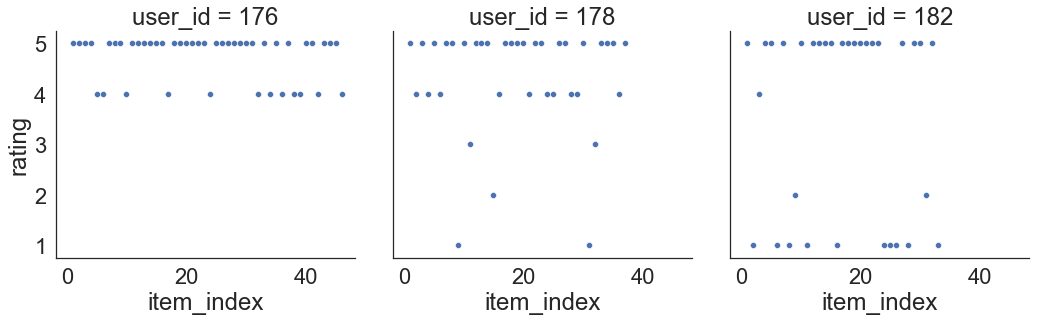

In [11]:
import matplotlib.pyplot as plt
#low
fig_path = 'D:/exp/Social Recommendation/ESNRec/data/ciao/ciao_stand.png'
ciao_176_stand = sns.load_dataset("ciao_176_stand",cache=True)
sns.set(font_scale=2, style='white')
sns.relplot(x="item_index",y="rating",col="user_id",data=ciao_176_stand,palette='flare')
plt.savefig("boxplot03.pdf",dpi=600)

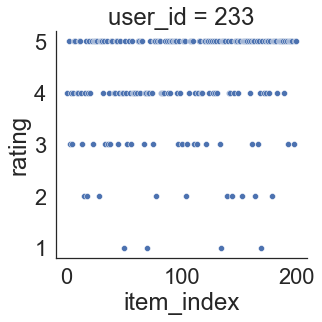

In [8]:
#medium
ciao_233_stand = sns.load_dataset("ciao_233_stand",cache=True)
sns.relplot(x="item_index",y="rating",col="user_id",data=ciao_233_stand)

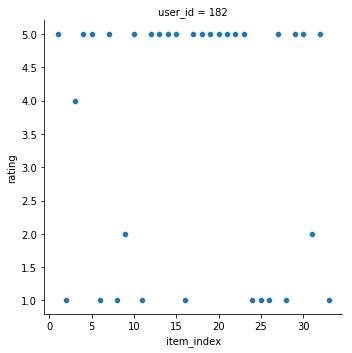

In [28]:
#high
ciao_182_stand = sns.load_dataset("ciao_182_stand",cache=True)
sns.relplot(x="item_index",y="rating",col="user_id",data=ciao_182_stand)

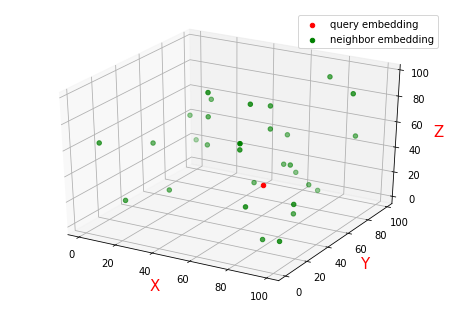

<Figure size 432x288 with 0 Axes>

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 空间三维画图
 
 
# 数据
 
# 数据１

#data1 = np.arange(1).reshape((2, 1))

# data的值如下：
# [[ 0  1  2]
#  [ 3  4  5]
#  [ 6  7  8]
#  [ 9 10 11]
#  [12 13 14]
#  [15 16 17]
#  [18 19 20]
#  [21 22 23]]
#x1 = data1[:, 0]  # [ 0  3  6  9 12 15 18 21]
#y1 = data1[:, 1]  # [ 1  4  7 10 13 16 19 22]
#z1 = data1[:, 2]  # [ 2  5  8 11 14 17 20 23]
x1 = [57]# [ 0  3  6  9 12 15 18 21]
y1 = [66]# [ 1  4  7 10 13 16 19 22]
z1 = [15]# [ 2  5  8 11 14 17 20 23]


# 数据２
data2 = np.random.randint(0, 100, (30, 3))
x2 = data2[:, 0]
y2 = data2[:, 1]
z2 = data2[:, 2]
 
 
# 绘制散点图
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x1, y1, z1, c='r', label='query embedding')
ax.scatter(x2, y2, z2, c='g', label='neighbor embedding')
 
 
# 绘制图例
ax.legend(loc='best')
 
 
# 添加坐标轴(顺序是Z, Y, X)
ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})
 
 
# 展示
plt.show()

plt.savefig("dense.pdf",dpi=600)